# Simulating an Attack on a Simplistic Symmetric Block Cipher
#### Malick Gaye - May 16, 2022

In [1]:
import numpy as np
import time
import qiskit as qk
from qiskit.circuit import QuantumCircuit, Parameter
import qutip as qt
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import pandas as pd
import random
from qiskit import IBMQ
%matplotlib inline
from IPython.display import display

In [2]:
num_shots=10000
n = 9
qr = qk.QuantumRegister(n) # Define quantum register
cr = qk.ClassicalRegister(n) # Define classical register

### Helpers

In [3]:
def init_state(circ, state, idx, n=9):
    if len(state) > n: return
    for i in range(len(state)):
        if state[i] == '1': circ.x(i + idx)
        if state[i] == '+': circ.h(i + idx)
        if state[i] == '-':
            circ.x(i + idx)
            circ.h(i + idx)
    circ.barrier()
    return circ

In [4]:
def present_s_box(circ, start_idx = 0):
    circ.cx(2+start_idx, 1+start_idx)
    circ.toffoli(1+start_idx, 2+start_idx, 3+start_idx)
    circ.toffoli(1+start_idx, 3+start_idx, 2+start_idx)
    circ.toffoli(0+start_idx, 2+start_idx, 1+start_idx)
    circ.cx(3+start_idx, 2+start_idx)
    circ.cx(1+start_idx, 2+start_idx)
    circ.cx(3+start_idx, 0+start_idx)
    circ.cx(0+start_idx, 1+start_idx)
    circ.x(0+start_idx)
    circ.toffoli(1+start_idx, 2+start_idx, 3+start_idx)
    circ.barrier()
    return circ

In [5]:
def present_s_box_inverse(circ, start_idx = 0):
    circ.toffoli(1+start_idx, 2+start_idx, 3+start_idx)
    circ.x(0+start_idx)
    circ.cx(0+start_idx, 1+start_idx)
    circ.cx(3+start_idx, 0+start_idx)
    circ.cx(1+start_idx, 2+start_idx)
    circ.cx(3+start_idx, 2+start_idx)
    circ.toffoli(0+start_idx, 2+start_idx, 1+start_idx)
    circ.toffoli(1+start_idx, 3+start_idx, 2+start_idx)
    circ.toffoli(1+start_idx, 2+start_idx, 3+start_idx)
    circ.cx(2+start_idx, 1+start_idx)
    circ.barrier()
    return circ

In [6]:
def check_equal(circ, i_1, i_2, a_i):
    circ.toffoli(i_1, i_2, a_i)
    circ.x([i_1, i_2])
    circ.toffoli(i_1, i_2, a_i)
    circ.x([i_1, i_2])
    return circ

In [7]:
def make_oracle(oracle, tgt_state, qr, num_state_qubits):
    qr_x = qr[:num_state_qubits]
    qr_a = qr[-1]
    oracle.barrier()
    for i in range(len(tgt_state)):
        if tgt_state[i] == '0': oracle.x([qr_x[i]])
    oracle.mcx(qr[[i for i, k in enumerate(tgt_state) if k != '_']],qr_a)
    for i in range(len(tgt_state)):
        if tgt_state[i] == '0': oracle.x([qr_x[i]])
    oracle.barrier()
    return oracle

In [8]:
def make_diffuser(num_state_qubits):
    qr = qk.QuantumRegister(num_state_qubits+1)
    cr = qk.ClassicalRegister(num_state_qubits+1)
    diffuser = qk.QuantumCircuit(qr, cr)
    qr_x = qr[:num_state_qubits]

    diffuser.h(qr_x)
    diffuser.x(qr_x)
    diffuser.barrier(qr_x)

    diffuser.h(qr_x[-1])
    diffuser.mcx(qr_x[0:-1],qr_x[-1])
    diffuser.h(qr_x[-1])
    diffuser.barrier(qr_x)

    diffuser.x(qr_x)
    diffuser.h(qr_x)
    diffuser.barrier(qr_x)
    
    return diffuser

In [9]:
sbox_depth = 4
def sbox(initial_state, backend=qk.Aer.get_backend('qasm_simulator'), invert=False, show_circuit=False, n=9, transpile=False):
    qr = qk.QuantumRegister(n) # Define quantum register
    cr = qk.ClassicalRegister(n) # Define classical register
    circ = qk.QuantumCircuit(qr,cr)
    circ = init_state(circ, initial_state, 0)
    for i in range(int(len(initial_state) / sbox_depth)):
        if invert: circ = present_s_box_inverse(circ, i * sbox_depth)
        else: circ = present_s_box(circ, i * sbox_depth)
    circ.measure(qr[:len(initial_state)], cr[:len(initial_state)])
    if show_circuit: display(circ.draw('mpl'))
    if transpile:
        circ = qk.transpile(circ, basis_gates=['cx, id, rz, sx, x'])
        circ.reset(qr)
    job = qk.execute(circ, backend=backend,shots=num_shots)
    result = job.result()
    #qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5)) #check that all states have nearly equal probability 1/16
    return (max(result.get_counts())[::-1])[:len(initial_state)]

In [69]:
def remove_outliers(e_times, d_times):
    for i in range(len(e_times)):
        temp = e_times.copy()
        temp.pop(i)
        if len(temp) != 0 and (e_times[i] > 2 * sum(temp) / len(temp)):
            e_times.pop(i)
            d_times.pop(i)
    
    return e_times, d_times

In [10]:
def most_frequent_element(lst): return max(set(lst), key=lst.count)

In [11]:
def match_s_box(num_it, tgt_state, backend, show_circuit=False):
    num_state_qubits = len(tgt_state)
    qr = qk.QuantumRegister(num_state_qubits+1)
    cr = qk.ClassicalRegister(num_state_qubits+1)
    grover = qk.QuantumCircuit(qr,cr)
    grover = init_state(grover, '+'*num_state_qubits, 0)
    for i in range(int(num_state_qubits / sbox_depth)): grover = present_s_box(grover, i * sbox_depth)
    for i in range(num_it):
        grover = make_oracle(grover, tgt_state, qr, num_state_qubits)
        grover.compose(make_diffuser(num_state_qubits), inplace=True)
    for i in range(int(num_state_qubits / sbox_depth)): grover = present_s_box_inverse(grover, i * sbox_depth) # Uncomputation
    grover.measure(qr[:num_state_qubits], cr[:num_state_qubits])
    if show_circuit: display(grover.draw('mpl'))
    g_job = qk.execute(grover, backend=backend,shots=num_shots)
    g_result = g_job.result()
    return g_result

### Hash Preimage Search

Given an encrypted state $m'$, find a state $m$ such that hash$(m) = m'$.

In [12]:
def grovers_search_preimage_resulting_in_collision(encrypted_state, backend=qk.Aer.get_backend('qasm_simulator'), max_k=10, verbose=True, show_circuit=False):
    matches = []
    print("Starting decryption of {}:".format(encrypted_state))
    for i in range(1, max_k):
        res = match_s_box(i, encrypted_state, backend, show_circuit=show_circuit)
        match = max(res.get_counts(), key = res.get_counts().get)
        prob = res.get_counts()[match] / sum(res.get_counts().values())
        if verbose: print("    k = %d: Input state most likely generating collision = %s, p = %.2f" % (i, (match[::-1])[:len(encrypted_state)], prob))
        matches.append((match[::-1])[:len(encrypted_state)])
    return most_frequent_element(matches)

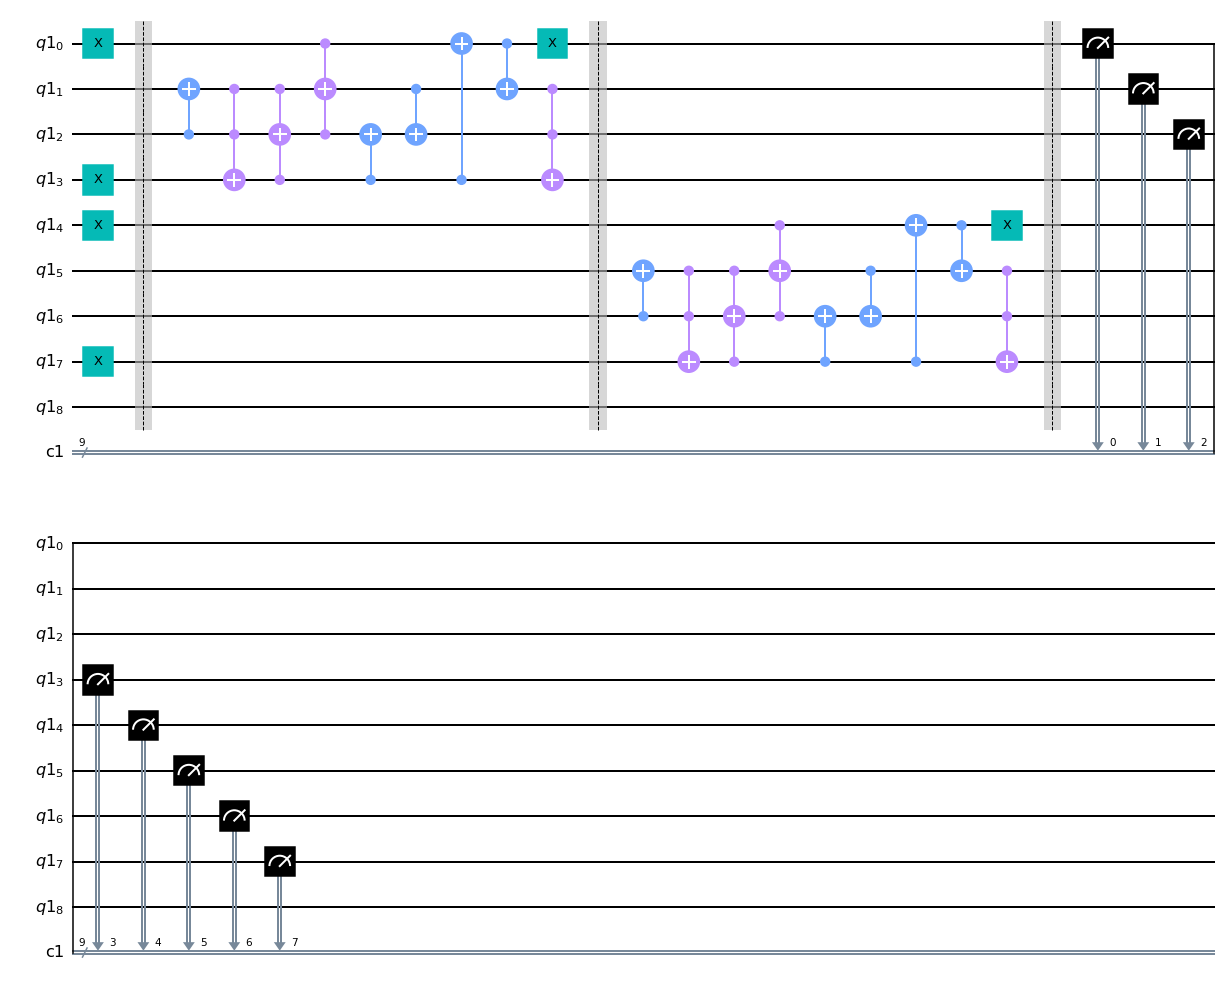

Encrypted state = 10111011, generated by initial state = 10011001

Ensuring Grover's algorithm finds the correct initial state given an encrypted state:
Starting decryption of 10111011:
    k = 1: Input state most likely generating collision = 10011001, p = 0.02
    k = 2: Input state most likely generating collision = 10011001, p = 0.05
    k = 3: Input state most likely generating collision = 10011001, p = 0.09
    k = 4: Input state most likely generating collision = 10011001, p = 0.15
    k = 5: Input state most likely generating collision = 10011001, p = 0.20
    k = 6: Input state most likely generating collision = 10011001, p = 0.26
    k = 7: Input state most likely generating collision = 10011001, p = 0.33
    k = 8: Input state most likely generating collision = 10011001, p = 0.38
    k = 9: Input state most likely generating collision = 10011001, p = 0.43
Given encrypted state 10111011, an input state 10011001 is predicted


In [13]:
initial_state = '10011001'
encrypted_state = sbox(initial_state, show_circuit=True)

print("Encrypted state = {}, generated by initial state = {}".format(encrypted_state, initial_state))
print()
print("Ensuring Grover's algorithm finds the correct initial state given an encrypted state:")

predicted_state = grovers_search_preimage_resulting_in_collision(encrypted_state)
print("Given encrypted state {}, an input state {} is predicted".format(encrypted_state, predicted_state))

## The Transmission Class

In [14]:
class Transmission:
    # Constructor
    def __init__(self, plaintext, verbose=False, backend=qk.Aer.get_backend('qasm_simulator'), half_byte=False):
        self.plaintext = plaintext
        self.ciphertext = ''
        
        self.encrypted = False
        self.half_byte = half_byte
        self.verbose = verbose
        self.backend = backend
        
        self.__encryption_times = []
        self.__decryption_times = []
        
        self.__exp_plaintext()
        
    # Boolean return indicating whether encrypted/decrypted
    def encrypted(self): return self.encrypted
    def decrypted(self): return not self.encrypted

    # Return ciphertext IFF it's available
    def ciphertext(self):
        if self.encrypted: return self.ciphertext
        else: return None
    
    # Return plaintext IFF it's available
    def plaintext(self):
        if self.encrypted: return None
        else: return self.plaintext
    
    # Look at a transmission's raw contents (in binary); may either be encrypted or unencrypted
    def view(self):
        if self.encrypted: return self.ciphertext
        else: return self.plaintext
    
    # Encrypt a message by putting it into sbox; track time associated w/ circuit execution
    def encrypt(self):
        if self.encrypted: return # already encrypted
        
        old_plaintext = self.plaintext
        start = time.time() # for tracking elapsed time
        self.ciphertext = sbox(self.plaintext, backend=self.backend,n=len(self.plaintext)+1, transpile=self.half_byte) # present s-box
        self.plaintext = '' # this should not be available after encryption
        elapsed_time = time.time() - start
        self.__encryption_times.append(elapsed_time)
        
        if self.verbose: self.__print_message(old_plaintext, self.ciphertext, elapsed_time, True)
        self.encrypted = True
        
    # Grover search for a preimage that results in a collision with the known encrypted state
    def decrypt(self):
        if not self.encrypted: return # already decrypted
        
        old_ciphertext = self.ciphertext
        start = time.time() # for tracking elapsed time
        self.plaintext = grovers_search_preimage_resulting_in_collision(self.ciphertext, self.backend, verbose=self.verbose)
        self.ciphertext = '' # this should not be available after decryption
        elapsed_time = time.time() - start
        self.__decryption_times.append(elapsed_time)
        
        if self.verbose: self.__print_message(old_ciphertext, self.plaintext, elapsed_time, False)
        self.encrypted = False
        
    # Return average encryption time
    def avg_encryption_time(self):
        if len(self.__encryption_times) == 0: return None
        return sum(self.__encryption_times) / len(self.__encryption_times)
    
    # Return average decryption time
    def avg_decryption_time(self):
        if len(self.__decryption_times) == 0: return None
        return sum(self.__decryption_times) / len(self.__decryption_times)
    
    # Return list of encryption/decryption times
    def encryption_times(self): return self.__encryption_times
    def decryption_times(self): return self.__decryption_times
    
    # Return ASCII representation of char if it is either a full byte or a half byte (nothing if not 4 or 8 chars)
    def to_char(self):
        if (not self.half_byte and len(self.plaintext) == 8) or (self.half_byte and len(self.plaintext) == 4): return chr(int(self.plaintext, 2))
        elif (not self.half_byte and len(self.ciphertext) == 8) or (self.half_byte and len(self.ciphertext) == 4): return chr(int(self.ciphertext, 2))
        return None
        
    ## PRIVATE METHODS
    
    # Append extra '0's to the front of the number in case its length is not a multiple of sbox_depth
    def __exp_plaintext(self):
        if len(self.plaintext) != 0 and len(self.plaintext) % sbox_depth == 0: return
        elif len(self.plaintext) == 0: return '0' * sbox_depth
        for i in range(sbox_depth - len(self.plaintext) % sbox_depth):
            self.plaintext = '0' + self.plaintext
        
    # Simply print encryption/decryption diagnostic info (eg. 'Encryption: 000101011101100000101101 --> 011000111001010000011001; elapsed time 10.622056722640991s')
    def __print_message(self, text1, text2, elapsed_time, encryption):
        print("{}cryption: {} --> {}; elapsed time {}s".format('En' if encryption else 'De', text1, text2, elapsed_time))
        if not encryption: print()

#### Demonstration of Transmission Object

In [15]:
var = Transmission('01101', verbose=True)
var.encrypt()
var.decrypt()

Encryption: 00001101 --> 10001001; elapsed time 0.04035305976867676s
Starting decryption of 10001001:
    k = 1: Input state most likely generating collision = 00001101, p = 0.02
    k = 2: Input state most likely generating collision = 00001101, p = 0.05
    k = 3: Input state most likely generating collision = 00001101, p = 0.09
    k = 4: Input state most likely generating collision = 00001101, p = 0.14
    k = 5: Input state most likely generating collision = 00001101, p = 0.21
    k = 6: Input state most likely generating collision = 00001101, p = 0.27
    k = 7: Input state most likely generating collision = 00001101, p = 0.33
    k = 8: Input state most likely generating collision = 00001101, p = 0.38
    k = 9: Input state most likely generating collision = 00001101, p = 0.42
Decryption: 10001001 --> 00001101; elapsed time 3.8097856044769287s



### Encryption/Decryption Times as a Function of Plaintext Size

In [16]:
def gen_plaintexts(plaintext_size, num_plaintexts):
    if num_plaintexts < 1 or plaintext_size < 1: return None
    plaintexts = []
    for i in range(num_plaintexts):
        plaintexts.append(str(format(random.randint(0, 2**(plaintext_size-1)), "b")))
        while len(plaintexts[i]) < plaintext_size: plaintexts[i] = '0' + plaintexts[i]
    return plaintexts

In [17]:
def encrypt_decrypt_function_of_plaintext_size(max_plaintext_size, num_plaintexts, backend=qk.Aer.get_backend('qasm_simulator')):
    if max_plaintext_size < sbox_depth: return
    e_times = []
    d_times = []
    while (max_plaintext_size % sbox_depth != 0): max_plaintext_size += 1
    for i in range(sbox_depth, max_plaintext_size+1, sbox_depth):
        plaintexts = gen_plaintexts(i, num_plaintexts)
        for j in range(num_plaintexts):
            msg = Transmission(plaintexts[j], backend=backend, verbose=True)
            msg.encrypt() # encryption destroys plaintext
            msg.decrypt() # decryption destroys ciphertext
            e_times.append(msg.encryption_times()[0])
            d_times.append(msg.decryption_times()[0])
        print()
    return e_times, d_times

In [18]:
def conv_str_to_transmissions_list(string, backend=qk.Aer.get_backend('qasm_simulator'), verbose=True):
    res = ''.join(format(ord(i), '08b') for i in string)
    words = []
    objs = []
    for i in range(int(len(res) / 8)): words.append(res[8*i:8*(i+1)])
    for i in range(len(words)): objs.append(Transmission(words[i], verbose=verbose, backend=backend))
    return objs

In [19]:
# Functions to encrypt or decrypt a list of Transmission objects

def encrypt_transmissions(unencrypted_transmissions):
    if len(unencrypted_transmissions) == 0: return None
    Transmission('0', backend=unencrypted_transmissions[0].backend).encrypt() # dummy; makes sure job wait time not counted into elapsed_time
    for i in range(len(unencrypted_transmissions)):
        unencrypted_transmissions[i].encrypt()
    return unencrypted_transmissions # now encrypted
        
def decrypt_transmissions(encrypted_transmissions):
    if len(encrypted_transmissions) == 0: return None
    Transmission('0', backend=encrypted_transmissions[0].backend).encrypt() # dummy; makes sure job wait time not counted into elapsed_time
    for i in range(len(encrypted_transmissions)):
        encrypted_transmissions[i].decrypt()
    return encrypted_transmissions # now unencrypted

In [20]:
def encrypt_message(string, backend=qk.Aer.get_backend('qasm_simulator'), verbose=True, half_byte=False):
    if half_byte:
        words = string.split(' ')
        t_list = []
        for i in range(len(words)):
            t_list.append(Transmission(words[i], verbose=verbose, backend=backend, half_byte=True))
        return encrypt_transmissions(t_list)
    return encrypt_transmissions(conv_str_to_transmissions_list(string, backend=backend, verbose=verbose))

#### Example Attack

Generate several transmissions, encrypt them, decrypt them. Using simulator backend for now. If you look at the implementation of the Transmission class, you see that plaintext *is* destroyed during encryption, and the decryption method is done via finding collisions through Grover's search.

In [54]:
ex_num_plaintexts = 40
ex_max_plaintexts = 8
n=ex_max_plaintexts+1
example_encrypt_times, example_decrypt_times = encrypt_decrypt_function_of_plaintext_size(ex_max_plaintexts, ex_num_plaintexts) # max plaintext length = 20, 3 plaintexts per length

Encryption: 0101 --> 0011; elapsed time 0.027576923370361328s
Starting decryption of 0011:
    k = 1: Input state most likely generating collision = 0101, p = 0.27
    k = 2: Input state most likely generating collision = 0101, p = 0.48
    k = 3: Input state most likely generating collision = 0101, p = 0.51
    k = 4: Input state most likely generating collision = 0101, p = 0.32
    k = 5: Input state most likely generating collision = 0101, p = 0.09
    k = 6: Input state most likely generating collision = 1111, p = 0.07
    k = 7: Input state most likely generating collision = 0101, p = 0.21
    k = 8: Input state most likely generating collision = 0101, p = 0.45
    k = 9: Input state most likely generating collision = 0101, p = 0.53
Decryption: 0011 --> 0101; elapsed time 1.9609653949737549s

Encryption: 0011 --> 1100; elapsed time 0.025544166564941406s
Starting decryption of 1100:
    k = 1: Input state most likely generating collision = 0011, p = 0.27
    k = 2: Input state most

    k = 2: Input state most likely generating collision = 0010, p = 0.48
    k = 3: Input state most likely generating collision = 0010, p = 0.51
    k = 4: Input state most likely generating collision = 0010, p = 0.33
    k = 5: Input state most likely generating collision = 0010, p = 0.09
    k = 6: Input state most likely generating collision = 1111, p = 0.07
    k = 7: Input state most likely generating collision = 0010, p = 0.22
    k = 8: Input state most likely generating collision = 0010, p = 0.45
    k = 9: Input state most likely generating collision = 0010, p = 0.53
Decryption: 0001 --> 0010; elapsed time 2.0665364265441895s

Encryption: 0001 --> 0110; elapsed time 0.022665023803710938s
Starting decryption of 0110:
    k = 1: Input state most likely generating collision = 0001, p = 0.27
    k = 2: Input state most likely generating collision = 0001, p = 0.50
    k = 3: Input state most likely generating collision = 0001, p = 0.51
    k = 4: Input state most likely generating

    k = 5: Input state most likely generating collision = 0100, p = 0.09
    k = 6: Input state most likely generating collision = 1101, p = 0.07
    k = 7: Input state most likely generating collision = 0100, p = 0.21
    k = 8: Input state most likely generating collision = 0100, p = 0.45
    k = 9: Input state most likely generating collision = 0100, p = 0.53
Decryption: 1111 --> 0100; elapsed time 1.6401851177215576s

Encryption: 0101 --> 0011; elapsed time 0.02512216567993164s
Starting decryption of 0011:
    k = 1: Input state most likely generating collision = 0101, p = 0.27
    k = 2: Input state most likely generating collision = 0101, p = 0.49
    k = 3: Input state most likely generating collision = 0101, p = 0.51
    k = 4: Input state most likely generating collision = 0101, p = 0.33
    k = 5: Input state most likely generating collision = 0101, p = 0.09
    k = 6: Input state most likely generating collision = 0001, p = 0.07
    k = 7: Input state most likely generating 

    k = 7: Input state most likely generating collision = 0011, p = 0.22
    k = 8: Input state most likely generating collision = 0011, p = 0.45
    k = 9: Input state most likely generating collision = 0011, p = 0.53
Decryption: 1100 --> 0011; elapsed time 2.015594720840454s

Encryption: 0101 --> 0011; elapsed time 0.02485203742980957s
Starting decryption of 0011:
    k = 1: Input state most likely generating collision = 0101, p = 0.27
    k = 2: Input state most likely generating collision = 0101, p = 0.49
    k = 3: Input state most likely generating collision = 0101, p = 0.51
    k = 4: Input state most likely generating collision = 0101, p = 0.32
    k = 5: Input state most likely generating collision = 0101, p = 0.10
    k = 6: Input state most likely generating collision = 0001, p = 0.07
    k = 7: Input state most likely generating collision = 0101, p = 0.21
    k = 8: Input state most likely generating collision = 0101, p = 0.45
    k = 9: Input state most likely generating c

    k = 8: Input state most likely generating collision = 00101100, p = 0.39
    k = 9: Input state most likely generating collision = 00101100, p = 0.43
Decryption: 00010010 --> 00101100; elapsed time 3.939988613128662s

Encryption: 00000100 --> 10001111; elapsed time 0.0376584529876709s
Starting decryption of 10001111:
    k = 1: Input state most likely generating collision = 00000100, p = 0.02
    k = 2: Input state most likely generating collision = 00000100, p = 0.05
    k = 3: Input state most likely generating collision = 00000100, p = 0.09
    k = 4: Input state most likely generating collision = 00000100, p = 0.14
    k = 5: Input state most likely generating collision = 00000100, p = 0.20
    k = 6: Input state most likely generating collision = 00000100, p = 0.27
    k = 7: Input state most likely generating collision = 00000100, p = 0.32
    k = 8: Input state most likely generating collision = 00000100, p = 0.38
    k = 9: Input state most likely generating collision = 000

    k = 3: Input state most likely generating collision = 01101110, p = 0.09
    k = 4: Input state most likely generating collision = 01101110, p = 0.15
    k = 5: Input state most likely generating collision = 01101110, p = 0.21
    k = 6: Input state most likely generating collision = 01101110, p = 0.27
    k = 7: Input state most likely generating collision = 01101110, p = 0.33
    k = 8: Input state most likely generating collision = 01101110, p = 0.38
    k = 9: Input state most likely generating collision = 01101110, p = 0.42
Decryption: 10100000 --> 01101110; elapsed time 4.106841564178467s

Encryption: 01011011 --> 00110111; elapsed time 0.04457569122314453s
Starting decryption of 00110111:
    k = 1: Input state most likely generating collision = 01011011, p = 0.02
    k = 2: Input state most likely generating collision = 01011011, p = 0.05
    k = 3: Input state most likely generating collision = 01011011, p = 0.09
    k = 4: Input state most likely generating collision = 01

    k = 9: Input state most likely generating collision = 01011010, p = 0.42
Decryption: 00111101 --> 01011010; elapsed time 3.3180911540985107s

Encryption: 00010001 --> 01100110; elapsed time 0.03711390495300293s
Starting decryption of 01100110:
    k = 1: Input state most likely generating collision = 00010001, p = 0.02
    k = 2: Input state most likely generating collision = 00010001, p = 0.05
    k = 3: Input state most likely generating collision = 00010001, p = 0.09
    k = 4: Input state most likely generating collision = 00010001, p = 0.15
    k = 5: Input state most likely generating collision = 00010001, p = 0.21
    k = 6: Input state most likely generating collision = 00010001, p = 0.27
    k = 7: Input state most likely generating collision = 00010001, p = 0.33
    k = 8: Input state most likely generating collision = 00010001, p = 0.39
    k = 9: Input state most likely generating collision = 00010001, p = 0.43
Decryption: 01100110 --> 00010001; elapsed time 3.510859489

    k = 4: Input state most likely generating collision = 01100111, p = 0.15
    k = 5: Input state most likely generating collision = 01100111, p = 0.20
    k = 6: Input state most likely generating collision = 01100111, p = 0.27
    k = 7: Input state most likely generating collision = 01100111, p = 0.33
    k = 8: Input state most likely generating collision = 01100111, p = 0.39
    k = 9: Input state most likely generating collision = 01100111, p = 0.42
Decryption: 10100101 --> 01100111; elapsed time 3.5702056884765625s

Encryption: 00010001 --> 01100110; elapsed time 0.03706550598144531s
Starting decryption of 01100110:
    k = 1: Input state most likely generating collision = 00010001, p = 0.02
    k = 2: Input state most likely generating collision = 00010001, p = 0.05
    k = 3: Input state most likely generating collision = 00010001, p = 0.10
    k = 4: Input state most likely generating collision = 00010001, p = 0.15
    k = 5: Input state most likely generating collision = 0

    k = 2: Input state most likely generating collision = 00100001, p = 0.05
    k = 3: Input state most likely generating collision = 00100001, p = 0.09
    k = 4: Input state most likely generating collision = 00100001, p = 0.15
    k = 5: Input state most likely generating collision = 00100001, p = 0.20
    k = 6: Input state most likely generating collision = 00100001, p = 0.27
    k = 7: Input state most likely generating collision = 00100001, p = 0.33
    k = 8: Input state most likely generating collision = 00100001, p = 0.39
    k = 9: Input state most likely generating collision = 00100001, p = 0.43
Decryption: 00010110 --> 00100001; elapsed time 3.803426742553711s




Linear fit: 89.36576170830094*(Encryption time) + -0.1323938245716874s


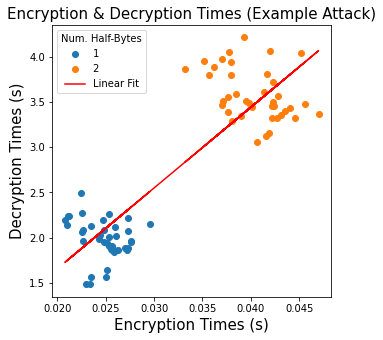

In [76]:
example_encrypt_times, example_decrypt_times = remove_outliers(example_encrypt_times, example_decrypt_times)
plt.figure(figsize=(5,5))
for i in range(int(ex_max_plaintexts / 4)):
    plt.scatter(example_encrypt_times[ex_num_plaintexts*i:ex_num_plaintexts*(i+1)], example_decrypt_times[ex_num_plaintexts*i:ex_num_plaintexts*(i+1)], marker="o", label=i+1)
    
m, b = np.polyfit(example_encrypt_times, example_decrypt_times, 1)
yfit = []
for i in range(len(example_encrypt_times)): yfit.append(m*example_encrypt_times[i]+b)
plt.plot(example_encrypt_times, yfit, color="red", label="Linear Fit")
plt.legend(title="Num. Half-Bytes", fontsize=10)
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (Example Attack)", fontsize=15)
print("Linear fit: {}*(Encryption time) + {}s".format(m, b))

Text(0.5, 1.0, 'Encryption & Decryption Times (Example, 1 half-byte)')

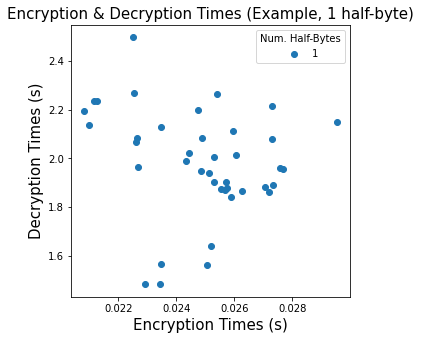

In [77]:
plt.figure(figsize=(5,5))
plt.scatter(example_encrypt_times[:ex_num_plaintexts], example_decrypt_times[:ex_num_plaintexts], marker="o", label=1)
plt.legend(title="Num. Half-Bytes", fontsize=10)
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (Example, 1 half-byte)", fontsize=15)

Text(0.5, 1.0, 'Encryption & Decryption Times (Example, 1 byte)')

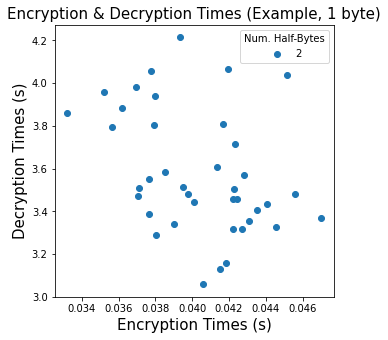

In [78]:
plt.figure(figsize=(5,5))
plt.scatter(example_encrypt_times[ex_num_plaintexts:], example_decrypt_times[ex_num_plaintexts:], marker="o", label=2)
plt.legend(title="Num. Half-Bytes", fontsize=10)
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (Example, 1 byte)", fontsize=15)

## Orchestrating a Full Attack

In [61]:
n = 9
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-05-16 01:06:37,480: Credentials are already in use. The existing account in the session will be replaced.


#### Sender Encrypts Outgoing Messages

Combined, our encryption/decryption schemes require 8 qubits to represent a character (one byte) and an ancilla.

In [62]:
out_transmissions = encrypt_message("Hi 123")

Encryption: 01001000 --> 11110100; elapsed time 0.036223411560058594s
Encryption: 01101001 --> 10101011; elapsed time 0.04294013977050781s
Encryption: 00100000 --> 00011000; elapsed time 0.03289914131164551s
Encryption: 00110001 --> 11000110; elapsed time 0.03726553916931152s
Encryption: 00110010 --> 11000001; elapsed time 0.03894352912902832s
Encryption: 00110011 --> 11001100; elapsed time 0.038202524185180664s


#### Eavesdropper Intercepts Outgoing Messages

The eavesdropper uses Grover's algorithm to decrypt the set of ciphertexts as they have no information about the input plaintext. They do have knowledge about encryption layers, as well-designed encryption schemes avoid security through obfuscation.

First they view the encrypted messages:

In [63]:
for i in range(len(out_transmissions)):
    print("Bitstring = {}; ASCII Representation = {}".format(out_transmissions[i].view(), out_transmissions[i].to_char()))

Bitstring = 11110100; ASCII Representation = ô
Bitstring = 10101011; ASCII Representation = «
Bitstring = 00011000; ASCII Representation = 
Bitstring = 11000110; ASCII Representation = Æ
Bitstring = 11000001; ASCII Representation = Á
Bitstring = 11001100; ASCII Representation = Ì


Then they decrypt the transmissions and view the messages again.

In [64]:
out_transmissions_decrypted = decrypt_transmissions(out_transmissions)
for i in range(len(out_transmissions_decrypted)):
    print("Bitstring = {}; ASCII Representation = {}".format(out_transmissions_decrypted[i].view(), out_transmissions_decrypted[i].to_char()))

Starting decryption of 11110100:
    k = 1: Input state most likely generating collision = 01001000, p = 0.02
    k = 2: Input state most likely generating collision = 01001000, p = 0.05
    k = 3: Input state most likely generating collision = 01001000, p = 0.09
    k = 4: Input state most likely generating collision = 01001000, p = 0.14
    k = 5: Input state most likely generating collision = 01001000, p = 0.20
    k = 6: Input state most likely generating collision = 01001000, p = 0.26
    k = 7: Input state most likely generating collision = 01001000, p = 0.33
    k = 8: Input state most likely generating collision = 01001000, p = 0.39
    k = 9: Input state most likely generating collision = 01001000, p = 0.43
Decryption: 11110100 --> 01001000; elapsed time 3.21134090423584s

Starting decryption of 10101011:
    k = 1: Input state most likely generating collision = 01101001, p = 0.02
    k = 2: Input state most likely generating collision = 01101001, p = 0.05
    k = 3: Input sta

#### Packaging Encryption & Attack into Function

In [65]:
def send_and_attack(out_msg="0", backend = qk.Aer.get_backend('qasm_simulator'), num_shots = 10000, n = 9, half_byte=False):
    print("BACKEND: {} ------------------------------------".format(backend))
    print()
    print("SENDER ENCRYPTS & SENDS OUTGOING MESSAGE:")
    start_e = time.time()
    out_transmissions = encrypt_message(out_msg, backend=backend, half_byte=half_byte)
    elapsed_encryption_time = time.time() - start_e
    
    print()
    print("MESSAGE ENCRYPTED: total t = {}s".format(elapsed_encryption_time))
    
    print()
    print("EAVESDROPPER INTERCEPTS ENCRYPTED MESSAGE:")
    for i in range(len(out_transmissions)):
        print("   Bitstring = {}; ASCII Representation = {}".format(out_transmissions[i].view(), out_transmissions[i].to_char()))
       
    print()
    print("EAVESDROPPER BEGINS DECRYPTING ENCRYPTED MESSAGE VIA GROVER SEARCH:")
    start_d = time.time()
    out_transmissions_decrypted = decrypt_transmissions(out_transmissions)
    elapsed_decryption_time = time.time() - start_d
    
    print("EAVESDROPPER VIEWS DECRYPTED MESSAGE (total time = {}s):".format(elapsed_decryption_time))
    for i in range(len(out_transmissions_decrypted)):
        print("   Bitstring = {}; ASCII Representation = {}".format(out_transmissions_decrypted[i].view(), out_transmissions_decrypted[i].to_char()))
        
    e_times = [] # encryption times of all words
    d_times = [] # decryption times of all words
    for i in range(len(out_transmissions_decrypted)):
        e_times = e_times + out_transmissions_decrypted[i].encryption_times()
        d_times = d_times + out_transmissions_decrypted[i].decryption_times()
    
    print()
    return e_times, d_times

## Looking at Encryption vs. Decryption Times on Various Systems

### Collecting Attack Results

In [66]:
num_shots = 500
n = 9

In [67]:
msg = "hi! bye"
times_dict = { 'qasm_simulator':send_and_attack(out_msg=msg),
               'ibmq_qasm_simulator':send_and_attack(out_msg=msg, backend=provider.get_backend('ibmq_qasm_simulator')),
               'simulator_mps':send_and_attack(out_msg=msg, backend=provider.get_backend('simulator_mps'))
             }

BACKEND: qasm_simulator ------------------------------------

SENDER ENCRYPTS & SENDS OUTGOING MESSAGE:
Encryption: 01101000 --> 10100100; elapsed time 0.018984556198120117s
Encryption: 01101001 --> 10101011; elapsed time 0.020830869674682617s
Encryption: 00100001 --> 00010110; elapsed time 0.015398740768432617s
Encryption: 00100000 --> 00011000; elapsed time 0.01409769058227539s
Encryption: 01100010 --> 10100001; elapsed time 0.017270565032958984s
Encryption: 01111001 --> 01011011; elapsed time 0.02174687385559082s
Encryption: 01100101 --> 10100011; elapsed time 0.019526004791259766s

MESSAGE ENCRYPTED: total t = 0.14143586158752441s

EAVESDROPPER INTERCEPTS ENCRYPTED MESSAGE:
   Bitstring = 10100100; ASCII Representation = ¤
   Bitstring = 10101011; ASCII Representation = «
   Bitstring = 00010110; ASCII Representation = 
   Bitstring = 00011000; ASCII Representation = 
   Bitstring = 10100001; ASCII Representation = ¡
   Bitstring = 01011011; ASCII Representation = [
   Bitstring 

    k = 1: Input state most likely generating collision = 01000010, p = 0.01
    k = 2: Input state most likely generating collision = 01101000, p = 0.04
    k = 3: Input state most likely generating collision = 01101000, p = 0.11
    k = 4: Input state most likely generating collision = 01101000, p = 0.12
    k = 5: Input state most likely generating collision = 01101000, p = 0.22
    k = 6: Input state most likely generating collision = 01101000, p = 0.25
    k = 7: Input state most likely generating collision = 01101000, p = 0.36
    k = 8: Input state most likely generating collision = 01101000, p = 0.39
    k = 9: Input state most likely generating collision = 01101000, p = 0.46
Decryption: 10100100 --> 01101000; elapsed time 141.24864602088928s

Starting decryption of 10101011:
    k = 1: Input state most likely generating collision = 01101001, p = 0.03
    k = 2: Input state most likely generating collision = 01101001, p = 0.05
    k = 3: Input state most likely generating colli

    k = 6: Input state most likely generating collision = 01101001, p = 0.26
    k = 7: Input state most likely generating collision = 01101001, p = 0.33
    k = 8: Input state most likely generating collision = 01101001, p = 0.34
    k = 9: Input state most likely generating collision = 01101001, p = 0.45
Decryption: 10101011 --> 01101001; elapsed time 211.45170998573303s

Starting decryption of 00010110:
    k = 1: Input state most likely generating collision = 00100001, p = 0.02
    k = 2: Input state most likely generating collision = 00100001, p = 0.05
    k = 3: Input state most likely generating collision = 00100001, p = 0.09
    k = 4: Input state most likely generating collision = 00100001, p = 0.14
    k = 5: Input state most likely generating collision = 00100001, p = 0.19
    k = 6: Input state most likely generating collision = 00100001, p = 0.30
    k = 7: Input state most likely generating collision = 00100001, p = 0.34
    k = 8: Input state most likely generating colli

### Results Plotted

#### Combined Plot

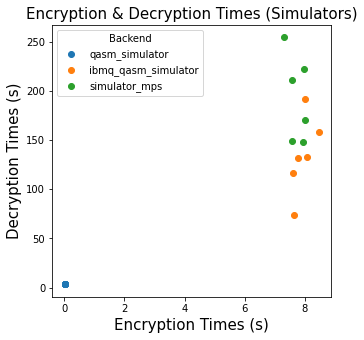

In [80]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict['qasm_simulator'][0], times_dict['qasm_simulator'][1], marker = "o", label = 'qasm_simulator')
plt.scatter(times_dict['ibmq_qasm_simulator'][0], times_dict['ibmq_qasm_simulator'][1], marker = "o", label = 'ibmq_qasm_simulator')
plt.scatter(times_dict['simulator_mps'][0], times_dict['simulator_mps'][1], marker = "o", label = 'simulator_mps')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (Simulators)", fontsize=15)
plt.legend(title="Backend", fontsize=10)

#### Individual Plots

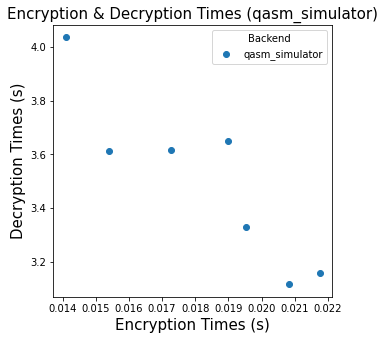

In [81]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict['qasm_simulator'][0], times_dict['qasm_simulator'][1], marker = "o", label = 'qasm_simulator')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (qasm_simulator)", fontsize=15)
plt.legend(title="Backend", fontsize=10)

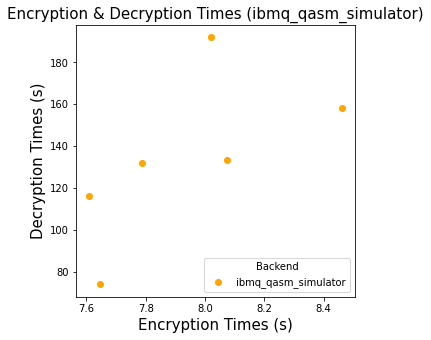

In [82]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict['ibmq_qasm_simulator'][0], times_dict['ibmq_qasm_simulator'][1], marker = "o", color="orange",label = 'ibmq_qasm_simulator')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (ibmq_qasm_simulator)", fontsize=15)
plt.legend(title="Backend", fontsize=10)

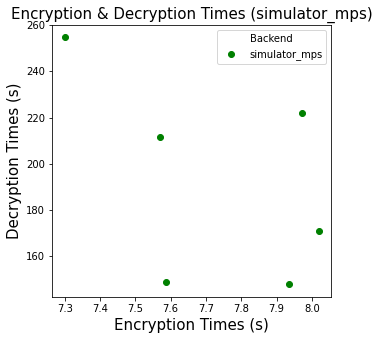

In [83]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict['simulator_mps'][0], times_dict['simulator_mps'][1], marker = "o", color="green",label = 'simulator_mps')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (simulator_mps)", fontsize=15)
plt.legend(title="Backend", fontsize=10)

### Half-Byte Outputs

I can only access real systems of up to 5 qubits, which means that we need to lower the word size to a half-byte, four characters. The last qubit must be used as an ancilla for Grover decryption. Unfortunately this means that our words are no longer ASCII compliant (as ASCII characters corresponding to [0, 15], the range of values for a half-byte, aren't really legible text), and we skip string conversion when we generate our Transmission objects. So at this point we are more focused on comparing bitstrings.

Note that this takes a very long amount of time as circuits must be transpiled first to conform with the machines' basis gate set!

In [ ]:
n = 5

In [ ]:
in_q = "1001 1110 0000" # 1001, 1110, 0000 are used to create transmission objects
times_dict_q = { 'ibmq_bogota':send_and_attack(in_q, backend=provider.get_backend('ibmq_bogota'), n=n, half_byte=True),
                 'ibmq_quito':send_and_attack(in_q, backend=provider.get_backend('ibmq_quito'), n=n, half_byte=True),
                 'ibmq_belem':send_and_attack(in_q, backend=provider.get_backend('ibmq_belem'), n=n, half_byte=True),
                 'ibmq_santiago':send_and_attack(in_q, backend=provider.get_backend('ibmq_santiago'), n=n, half_byte=True)
               }

In [ ]:
testvar = encrypt_message("0000", backend=provider.get_backend('ibmq_belem'), half_byte=True)

#### Combined Plot

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(times_dict_q['ibmq_bogota'][0], times_dict_q['ibmq_bogota'][1], marker = "o", label = 'ibmq_bogota')
plt.scatter(times_dict_q['ibmq_quito'][0], times_dict_q['ibmq_quito'][1], marker = "o", label = 'ibmq_quito')
plt.scatter(times_dict_q['ibmq_belem'][0], times_dict_q['ibmq_belem'][1], marker = "o", label = 'ibmq_belem')
plt.scatter(times_dict_q['ibmq_santiago'][0], times_dict_q['ibmq_santiago'][1], marker = "o", label = 'ibmq_santiago')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times (Real Hardware)", fontsize=15)
plt.legend(title="Machine", fontsize=10)

#### Individual Plots

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict_q['ibmq_bogota'][0], times_dict_q['ibmq_bogota'][1], marker = "o", label = 'ibmq_bogota')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times on ibmq_bogota", fontsize=15)
plt.legend(title="Machine", fontsize=10)

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict_q['ibmq_quito'][0], times_dict_q['ibmq_quito'][1], marker = "o", label = 'ibmq_quito')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times on ibmq_quito", fontsize=15)
plt.legend(title="Machine", fontsize=10)

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict_q['ibmq_belem'][0], times_dict_q['ibmq_belem'][1], marker = "o", label = 'ibmq_belem')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times on ibmq_belem", fontsize=15)
plt.legend(title="Machine", fontsize=10)

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(times_dict_q['ibmq_santiago'][0], times_dict_q['ibmq_santiago'][1], marker = "o", label = 'ibmq_santiago')
plt.xlabel("Encryption Times (s)", fontsize=15)
plt.ylabel("Decryption Times (s)", fontsize=15)
plt.title("Encryption & Decryption Times on ibmq_santiago", fontsize=15)
plt.legend(title="Machine", fontsize=10)